In [1]:
import os
os.environ["TRANSFORMERS_OFFLINE"] ="1"
os.environ["TRANSFORMERS_CACHE"] = "/home/gridsan/groups/maia_mechint/models"

In [2]:
cd ../

/home/gridsan/cguo/rep_e_icl/rep_e_icl


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from repe import repe_pipeline_registry
repe_pipeline_registry()
from tasks import get_task_dataset
from modules import *

In [5]:
from modules import *

In [7]:
model_name_or_path = "meta-llama/Llama-2-7b-hf"
# model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [ ]:
dataset_name = 'ade_corpus_v2-classification'
positive_prompt = "Pay attention to the following examples."
negative_prompt = "Don't pay attention to the following exmaples."
ntrain = 64 
test_num_examples = 3
user_tag = "[INST]"
assistant_tag = "[/INST]"

dataset = get_task_dataset(dataset_name, tokenizer, positive_prompt, negative_prompt, user_tag=user_tag, assistant_tag=assistant_tag, ntrain=ntrain, test_num_examples=test_num_examples)

getting dataset for ade_corpus_v2-classification
['Not Related', 'Related']
data len: 32
['Not Related', 'Related']
data len: 32
['Not Related', 'Related']
data len: 1568


In [ ]:
dataset["train"]["data"][0]

"[INST] Don't pay attention to the following exmaples. [/INST] A 57-year-old white male with unresectable pancreatic cancer received capecitabine in combination with radiation therapy followed by capecitabine alone given over approximately a 3-month time period.\nNot Related\nA 70-year-old man was admitted to our hospital because of dyspnea after taking an antihistaminic agent (homochlorcyclizine hydrochloride) for itching.\nRelated\n"

In [ ]:
(dataset["test"]["data"][0], dataset["test"]["labels"][0])

('[INST] [/INST] Pemphigus vulgaris (PV) is a rare but potentially fatal autoimmune bullous disorder which frequently affects the oral mucosa.\nNot Related\nThe clinical course suggests that caffeine, which is present in oolong tea, was mainly responsible for the rhabdomyolysis as well as the delirium, although severe hyponatremia has been reported to cause rhabdomyolysis on rare occasions.\nRelated\nTardive oculogyric crisis (OGC) is a dystonic syndrome that starts after long-term use of dopamine receptor antagonists.\n',
 'Not Related')

In [ ]:
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)
rep_reader = get_rep_reader(model, rep_reading_pipeline, dataset)

["[INST] Don't pay attention to the following exmaples. [/INST] A 57-year-old white male with unresectable pancreatic cancer received capecitabine in combination with radiation therapy followed by capecitabine alone given over approximately a 3-month time period.\nNot Related\nA 70-year-old man was admitted to our hospital because of dyspnea after taking an antihistaminic agent (homochlorcyclizine hydrochloride) for itching.\nRelated\n", '[INST] Pay attention to the following examples. [/INST] The ECG monitoring revealed sinus pause with markedly prolonged PQ interval and QRS width.\nNot Related\nThis observation illustrates that the pharmacological activation of the parathyroid CaR and other putative CaR on bone cells by calcimimetics did not protect against the occurrence of hypercalcemia of immobilization favored by a severe HPTH-II in a hemodialysis patient.\nNot Related\n', "[INST] Don't pay attention to the following exmaples. [/INST] Antiarrhythmic agents can cause pneumonitis.\

In [ ]:
len(dataset['test']['data'])

1568

In [ ]:
hidden_layers = get_hidden_layers(model)
H_tests = get_h_test(
    model, 
    rep_reading_pipeline, 
    rep_reader, 
    dataset
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 31.74 GiB total capacity; 27.38 GiB already allocated; 116.88 MiB free; 30.75 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

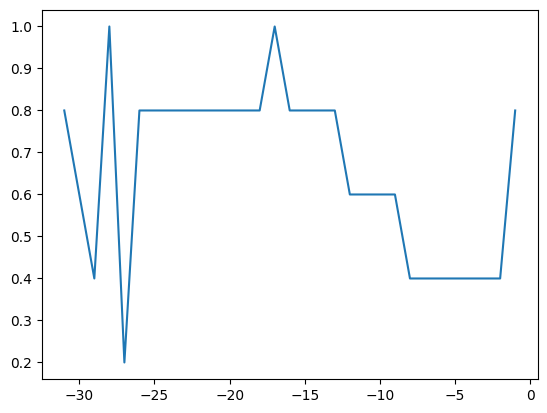

In [16]:
plot_correlation(rep_reader, H_tests, hidden_layers)

In [ ]:
data = dataset["test"]["data"][1]
test_data = get_test_data(model, tokenizer, [data])
wanted_layers = range(-1, -32, -1)
rep_reader_scores_dict, rep_reader_scores_mean_dict = get_rep_reader_scores_dict(model, tokenizer, 
                                                                                 rep_reading_pipeline, 
                                                                                 rep_reader, 
                                                                                 test_data
                                                                                 )

KeyboardInterrupt: 

In [ ]:
THRESHOLD = 0.0 # change this to alter sensitivity
input_ids = tokenizer.tokenize(test_data[0])
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(20, -20))

ValueError: '▁I' is not in list

In [17]:
max_layer = -10
min_layer = -25
layer_id = list(range(max_layer, min_layer, -1))

rep_control = get_rep_control(model, tokenizer, layer_id)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [18]:

baseline, pos_results, neg_results = get_rep_controlled_results(rep_reader, rep_control, dataset["test"]["data"], layer_id)

Done with baseline results!
Done with control outputs!
Done with neg control outputs


In [11]:
dataset["test"]["labels"][0]

'Not Related'

In [19]:
acc_dict = get_acc_dict(baseline, pos_results, neg_results, dataset["test"]["labels"])
acc_dict

Causes
1).
- Acute
The patient was
Clinical
The patient had
The patient was
A case of
A 5
Clinical
A 5
Congen
The most common
A 2
A 5
Amoeb
A 5
The most common
Rheum
The patient was
Benzar
BACKG
Clinical
[1]
The patient had
A 2
Amenorr
The patient had
Related
Related (
The patient had
BMJ
The patient was
Avoidance
Sweet'
The study was
Bosent
Drug-
A 4
Clinical
A 1
A 5
The patient had
Clinical
A 2
DIAGN
The patient was
The effect of
The patient was
A 4
The authors concluded
Clinical
The present study
A 1
The patient was
The patient with
The most common
The following ad
A case of
The diagnosis
A 6
A 6
Clinical
A 2
Bleom
A case of
Acetaz
A case of
Clinical
The patient was
The patient was
Avoidance
A 1
The patient was
10.
Causes
Drug Re
The patient was
The patient was
A 2
Carcin
The incidence
Cloz
A case of
Misdi
No other dru
Steroid
A case of
Causes
The study was
Amitri
The patient had
Crescent
The 1
A 5
Drug induced
No other ab
Clox
BACKG
Amiod
Insul
The other comp
Acute Cor
RESULTS
Drug

{'baseline_acc': 0.597, 'pos_acc': 0.024, 'neg_acc': 0.693}

In [21]:
for a, b, c in zip(baseline, pos_results, neg_results): 
    print(f"{a}, {b}, {c}")
    print("-----")

Not Related, Causes, Related
-----
Not Related, 1)., Not Related
-----
Case report:, - Acute, The patient was
-----
Not Related, The patient was, Not Related
-----
Not Related, Clinical, Not Relatively
-----
Not Related, The patient had, Not Related
-----
The patient was, The patient was, The patient was
-----
Not Related, A case of, Not Related
-----
RESULTS, A 5, The patient was
-----
Related, Clinical, Related
-----
Not Related, Related to, Not Related
-----
A 6, A 5, Not Related
-----
Not Related, Congen, Not Related
-----
Not Related, The most common, Not Related
-----
Not Related, A 2, Related
-----
Related, A 5, Related
-----
Not Related, Amoeb, Related
-----
Not Related, A 5, Not Related
-----
Not Related, The most common, Not Related
-----
Not Related, Rheum, Not Related
-----
Not Related, The patient was, Not Related
-----
Related, Benzar, Related
-----
OBJECTIVE, BACKG, Related
-----
Related, Clinical, Related
-----
Not Related, [1], Not Related
-----
Not Related, The patien

In [22]:
acc_dict

{'baseline_acc': 0.597, 'pos_acc': 0.024, 'neg_acc': 0.693}

'positive\n'